# Particle in a box


We will now investigate a particle of mass $m$ and energy $E$ with wavefunction $\psi$ in a box of length $L$ following the time-independent Schroedinger equation:

$$
\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}\left(E - V(x)\right)\psi(x)
$$

The potential is zero for $0 < x < 1$, and $\infty$ otherwise. Imposing Dirichlet boundary conditions, the analytic solution is

$$
\psi(x) = \sqrt{\frac{2}{L}}\sin\left(\frac{n\pi x}{L}\right)
$$

with energy eigenvalue of

$$
E_n = \frac{\hbar^2 n^2 \pi^2}{2m L^2}
$$

We will work in dimensionless units so that $\hbar = 1$, $m = 1$, $L = 1$. 

The way we will solve this is to use a shooting method. We will

- Impose the boundary condition at $x=0$.
- Initialize the derivative of $\psi$ to 1. 
- Initialize the energy to 5. 
- Propagate the dynamical system according to the Schroedinger equation.
- Use a root-finding method to iterate to find the correct energy. 

In [1]:
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt
from bvp import *

In [2]:

class ParticleInBox :
    def __init__( self, psiprime0 = 1.0 ) :
        self.xbounds = np.array([0.,1.])
        self.psibounds = np.array([0.,0.])
        self.psiprime0 = psiprime0
        self.state = np.array( [0., psiprime0, 1.0] )
        self.xvals = None
        self.psivals = None
        self.psiprimevals = None

    def psiflow( self, x, state ) :
        psi = state[0] ; psi_prime = state[1]; E = state[2]
        dpsi_dx = psi_prime
        d2psi_dx2 = -2*(E - self.V(x))*psi        
        return [ dpsi_dx, d2psi_dx2, 1.0 ]
        
    def V(self, x):           # potential function
        if x >= 0.0 and x <= 1.0:
            return 0.0
        else:
            return 1.0e30

    def shoot( self, E ) :
        self.state = [ self.psibounds[0], self.psiprime0, E]
        res = scipy.integrate.solve_ivp(fun=self.psiflow,
                                        t_span=self.xbounds,
                                        y0=self.state, 
                                        vectorized=True,
                                        atol=1e-11,rtol=1e-10,
                                        method='RK45', 
                                        max_step = (self.xbounds[1]-self.xbounds[0])/100)        
        
        self.xvals = res.t
        self.psivals = res.y[0]
        self.psiprimevals = res.y[1]
        self.E = res.y[2]
        self.state = [ self.psibounds[0], self.psiprimevals[-1], E ]        
        return self.psivals[-1] - self.psibounds[1]        
    
    
    def compute( self):
        res = scipy.optimize.root_scalar( self.shoot, bracket=[0, 10] )
        return res

In [3]:
Evals = np.arange(0.,1.,0.1)
p = ParticleInBox()
res = p.compute()

In [4]:
print(res)
print("True energy     = %4.2f" % (np.pi**2 * 0.5) )
print("Computed energy = %4.2f" % (res.root ))

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 4.432607855262077
True energy     = 4.93
Computed energy = 4.43


## Normalize the wavefunctions

In [5]:
psiana = np.sin(np.pi * p.xvals)
psiana = psiana / np.max(psiana)
p.psivals = p.psivals / np.max(p.psivals)

## Plot the wavefunctions

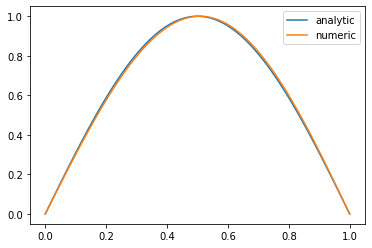

In [6]:
plt.plot(p.xvals, psiana, label="analytic")
plt.plot(p.xvals, p.psivals, label="numeric")

plt.legend()